1.QAOAはビット文字列を生成しますが、この文字列はそのグラフにとって最適解でしょうか？実機上の実験結果とローカルQASMシミュレーターの結果を比較してください。

まずはローカルQASMシミュレーターの結果を出力する。※qiskit textbookと同じコードを実行していくので詳細はtextbook参照。<br>
最初のステップとして、Qiskitとその他のPythonパッケージをロードする。

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


バタフライ・グラフでコスト関数を定義する。

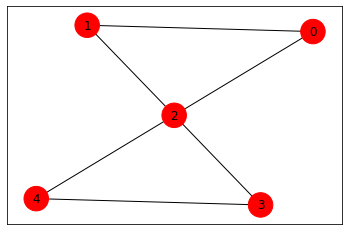

In [2]:
# Generating the butterfly graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

関数 $F_1(\gamma, \beta)$ を描画し、簡単なグリッドサーチを使って期待値を最大化するパラメーター $\gamma^*$ と $\beta^*$ を見つける。

/tmp/ipykernel_234/13536155.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax  = fig.gca(projection='3d')


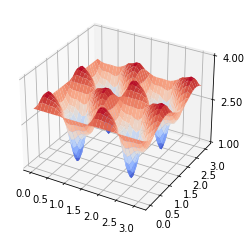


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [3]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

次にQAOA回路を実装する。

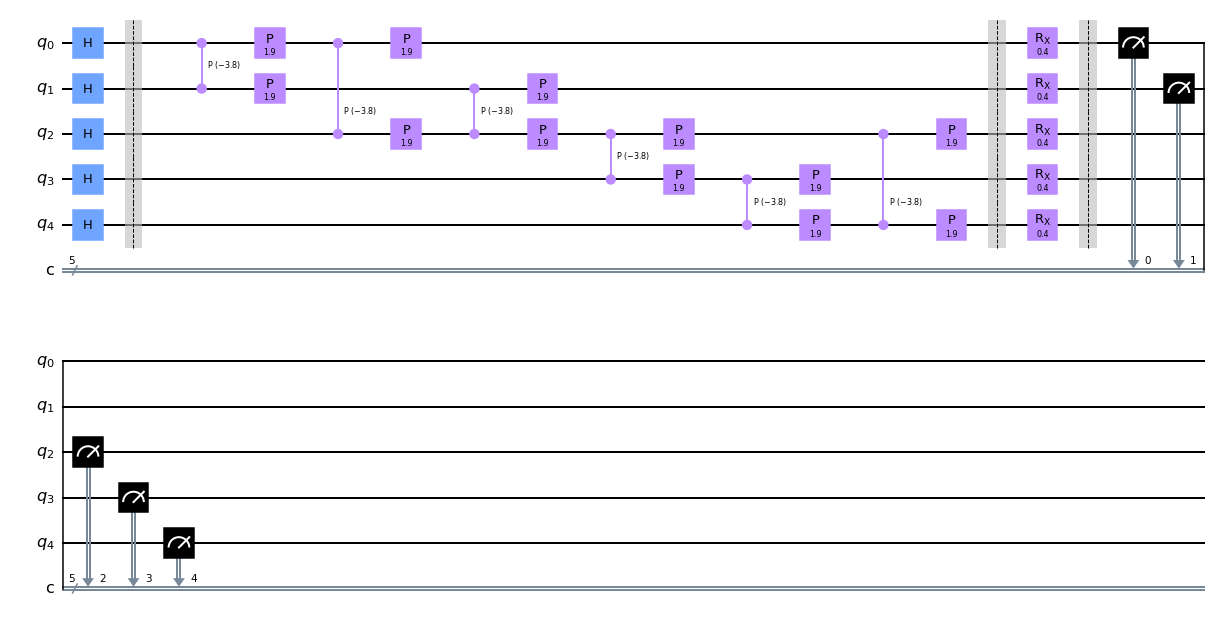

In [4]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

最後にビット文字列からコスト関数値を計算するルーチンを作成する。

In [5]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

まず、このアルゴリズムをローカルのQASMシミュレーターで実行していく。

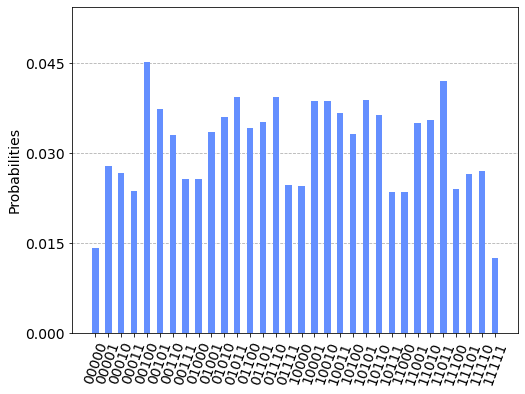

In [6]:
# run on local simulator
backend = Aer.get_backend("aer_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.28 while the true value is M1 = 3.43 

The approximate solution is x* = 11011 with C(x*) = 4 

The cost function is distributed as: 



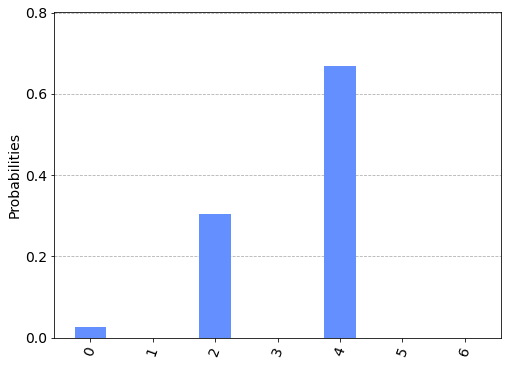

In [7]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)


このグラフはQAOAによって生成されたビット文字列を横軸：コスト（横切る枝の本数）、縦軸：確率に変換したものである。<br>
生成したビット文字列が最適解ならば横軸の値が4の確率が1となるはずである。<br>
よってこの文字列が最適解ではない。<br><br>
次にこのアルゴリズムを実機で実行していく。まずは実機のロードを行う。

In [8]:
provider = IBMQ.load_account()

次に実機での実行を行う。

Job Status: job has successfully run


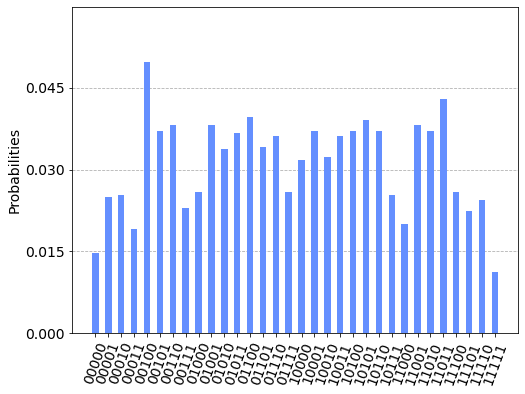

In [9]:
backend_lb = least_busy(provider.backends(simulator=False, operational=True))
shots = 2048

TQAOA = transpile(QAOA, backend_lb)
job_exp = backend.run(TQAOA, shots=shots)
job_monitor(job_exp)

exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 3.31 while the true value is M1 = 3.43 

The approximate solution is x* = 01110 with C(x*) = 4 

The cost function is distributed as: 



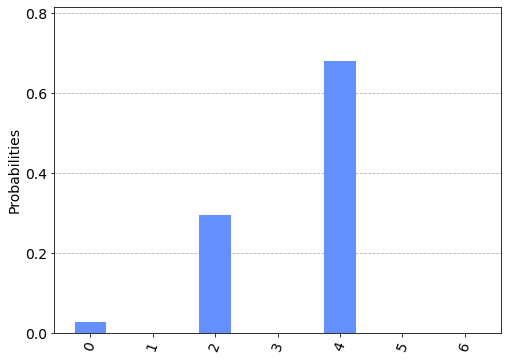

In [10]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

出力結果より、実機で実行した際もローカルQASMシミュレーターで実行した時と同じく最適解が得られていないことがわかる。<br><br>
この後の問題で上記グラフの出力は何度も行うため、サブルーチン化する。

In [11]:
def return_cost_function(counts, G):

    """
    Convert bitstring to cost function
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        hist: cost function
    """

    hist        = {}

    for k in range(len(G.edges())+1):
        hist[str(k)] = hist.get(str(k),0)
    
    for sample in list(counts.keys()):

        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
    
        # compute the expectation value and energy distribution
        hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
        
    return hist

3.Qiskitでの実装においての $F_1$ 正確な式が与えられました。<br><br>
○結果で得られたサンプルから期待値 $F_1(\gamma, \beta)$ を推定するルーチンを作成してください

期待値を推定するルーチンは以下の通り。

In [12]:
def compute_expectation(counts, G, flip=0):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
        flip: int
               0 convert bit string x to  C(x)
              -1 convert bit string x to -C(x)
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        x = [int(num) for num in list(bitstring)]
        
        if flip == 0:
            obj = cost_function_C(x, G)
        else:
            obj = -1 * cost_function_C(x, G)
        
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

問題１のローカルQASMシミュレーターの実行結果を用いて期待値を推定すると以下の通り。

In [13]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

res = compute_expectation(counts, G)

print('Expected value : %f' % res)

Expected value : 3.284600


○最適化ルーチン、例えばこのチュートリアルのVQEの例のSPSAなどを使って、サンプリングされた $F_1(\gamma, \beta)$ のパラメーターを数値的に最適化してください。$\gamma^*$ と $\beta^*$ に対し同じ値を見つけられましたか？

まずはQAOA回路の構築をルーチン化する。

In [14]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    # prepare the quantum and classical resisters
    nqubits = len(G.nodes)
    QAOA = QuantumCircuit(nqubits, nqubits)

    p = len(theta)//2  # number of alternating unitaries
    
    beta = theta[:p]
    gamma = theta[p:]
    

    # apply the layer of Hadamard gates to all qubits
    QAOA.h(range(nqubits))
    QAOA.barrier()
    
    for irep in range(0, p):
    
        # apply the Ising type gates with angle gamma along the edges in E
        for edge in G.edges:
            k = edge[0]
            l = edge[1]
            QAOA.cp(-2*gamma[irep], k, l)
            QAOA.p(gamma[irep], k)
            QAOA.p(gamma[irep], l)
        QAOA.barrier()
    
        # then apply the single qubit X - rotations with angle beta to all qubits
        QAOA.rx(2*beta[irep], range(nqubits))
        QAOA.barrier()
        
    QAOA.measure(range(nqubits),range(nqubits))

    return QAOA

次にQAOA回路を実行して、期待値 $F_1(\gamma, \beta)$ を出力するルーチンを作成する。

In [15]:
def get_expectation(G, p, mode, backend, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
        mode: int
            0 simulater
            1 real device
    """
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        
        if mode == 0:
            counts = backend.run(qc, seed_simulator=10, 
                                 nshots=512).result().get_counts()
        else:
            tqc = transpile(qc, backend)
            job_exp = backend.run(tqc, shots=512)
            job_monitor(job_exp)
            counts = job_exp.result().get_counts()
            
        return compute_expectation(counts, G, flip=1)
    
    return execute_circ

最後にSPSAを用いた最適化ルーチンを作成する。

In [16]:
def optimize_params(p, mode):
    
    """
    Optimize initial parameters
    
    Args:  
        p: depth
        mode: int
            0 simulater
            1 real device
                     
    Returns:
        ret: optimize result
    """
   
    if mode == 0:
        backend = Aer.get_backend('qasm_simulator')
    else:
        backend = least_busy(provider.backends(simulator=False, operational=True))
    
    expectation = get_expectation(G, p, mode, backend)

    # Initialize the SPSA optimizer
    optimizer = SPSA(maxiter=500)

    # Create the initial parameters
    params = np.random.rand(2 * p)
    ret = optimizer.optimize(num_vars=2 * p, objective_function=expectation, initial_point=params)
    
    return ret

ローカルQASMシミュレーターを用いてパラメータを最適化すると以下の通り。

In [17]:
ret = optimize_params(p=1, mode=0)

print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/tmp/ipykernel_234/971487406.py:28: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  ret = optimizer.optimize(num_vars=2 * p, objective_function=expectation, initial_point=params)


Output Error (Manhattan Distance): -3.921875
Parameters Found: [-1.89484218  0.56329861]


 グリッドサーチによって最適化したパラメータ$\gamma^*$ = 1.900と $\beta^* = 0.200$ と比較すると異なる値が出力されていることがわかる。<br>
 これは関数 $F_1(\gamma, \beta)$ が複数の極値を持っている（上述したグラフ参照）ことから、他の極値におけるパラメータを出力したと考えられる。<br>
 ここから数値的に最適化したパラメータの妥当性を評価していく。まず、生成したビット文字列は以下の通り。

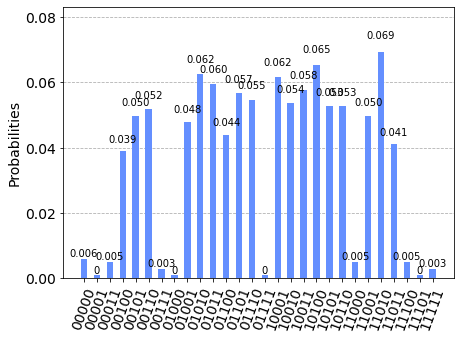

In [18]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, ret[0])

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

このビット文字列をコスト関数に変換すると以下の通り。


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.92 

The cost function is distributed as: 



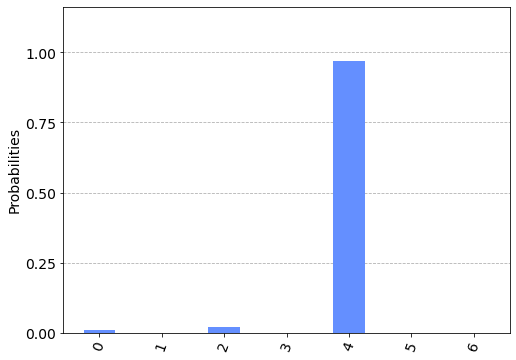

In [19]:
avr_C       = compute_expectation(counts, G)
hist        = return_cost_function(counts, G)
                
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f \n' % (avr_C))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

グリッドサーチにより最適化した結果と比較すると、数値的に最適化した今回の結果の方がより最適解に近いことがわかる。<br>
また、期待値を計算すると以下の通り。

In [20]:
res = compute_expectation(counts, G)

print('Expected value : %f' % res)

Expected value : 3.921875


こちらもグリッドサーチにより最適化した結果（Expected value : 3.310800）より最適解（Expected value : 4）に近い値が出力されていることがわかる。

4.セクション 5.3の試行回路は、深さ $p = 1$ で、ハードウェアと互換性があるよう意図したものでした。<br><br>
○問題2のルーチンを使って、 $p = 2,3$ に対しコスト関数 $F_p(\gamma, \beta)$ を評価してください。実機上での実行でどうなると思いますか?

まずQASMシミュレーターを用いてコスト関数を評価する。<br>
・$p = 2$ の場合

In [21]:
ret = optimize_params(p=2, mode=0)

print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/tmp/ipykernel_234/971487406.py:28: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  ret = optimizer.optimize(num_vars=2 * p, objective_function=expectation, initial_point=params)


Output Error (Manhattan Distance): -3.97265625
Parameters Found: [ 2.0490619   1.78719316 -0.25248362 -0.79472877]


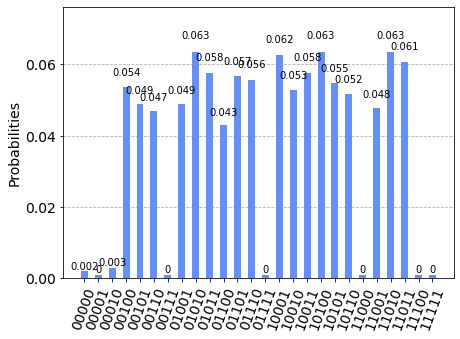

In [22]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, ret[0])

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.97 

The cost function is distributed as: 



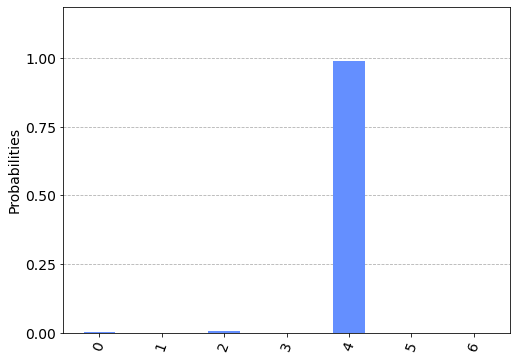

In [23]:
avr_C       = compute_expectation(counts, G)
hist        = return_cost_function(counts, G)
                
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f \n' % (avr_C))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [24]:
res = compute_expectation(counts, G)

print('Expected value : %f' % res)

Expected value : 3.972656


・$p = 3$ の場合

In [25]:
ret = optimize_params(p=3, mode=0)

print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/tmp/ipykernel_234/971487406.py:28: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  ret = optimizer.optimize(num_vars=2 * p, objective_function=expectation, initial_point=params)


Output Error (Manhattan Distance): -3.970703125
Parameters Found: [ 2.86596458  0.14229426 -0.43066505 -0.12799146  1.52332571  2.3801136 ]


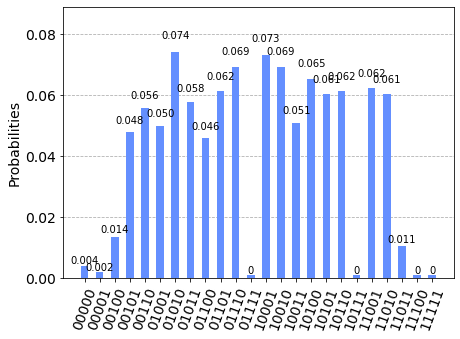

In [26]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, ret[0])

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.97 

The cost function is distributed as: 



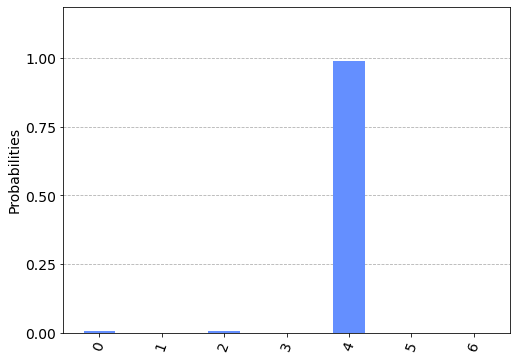

In [27]:
avr_C       = compute_expectation(counts, G)
hist        = return_cost_function(counts, G)
                
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f \n' % (avr_C))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [28]:
res = compute_expectation(counts, G)

print('Expected value : %f' % res)

Expected value : 3.970703


上記結果よりQASMシミュレーターの場合は深さpを大きくするにつれてより最適解（Expected value : 4）に近くなっていることがわかる。<br>
また、深さ$p = 2$以上で実機で実行する場合はハードウェアと互換性がなくなるため、QASMシミュレーターのように最適解に近い値は得られないことが予想される。<br>
実機かつ深さ$p = 2$で実行すると以下の通り。

In [ ]:
ret = optimize_params(p=2, mode=1)

print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/tmp/ipykernel_234/971487406.py:28: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  ret = optimizer.optimize(num_vars=2 * p, objective_function=expectation, initial_point=params)


Job Status: job is queued (85)    

In [ ]:
backend = least_busy(provider.backends(simulator=False, operational=True))
shots = 2048

qc_res = create_qaoa_circ(G, ret[0])

TQAOA = transpile(qc_res, backend)
job_exp = backend.run(TQAOA, shots=shots)
job_monitor(job_exp)

exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (8,6),bar_labels = False)

In [ ]:
counts = exp_results.get_counts()

avr_C       = compute_expectation(counts, G)
hist        = return_cost_function(counts, G)
                
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f \n' % (avr_C))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [ ]:
res = compute_expectation(counts, G)

print('Expected value : %f' % res)